<a href="https://colab.research.google.com/github/Tanish-04/Computer-Vision-Projects/blob/master/Image_Classification_using_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EfficientNet is a CNN architecture-based model. There are also other CNN architecture such as VGG (Visual Geometry Group), ResNet (Residual Network), Inception (GoogLeNet), and DenseNet (Densely Connected Convolutional Networks).

Selecting the right model depends on the kind of task you are performing considering the dataset size and complexity, computational resources, and accuracy requirements.

EfficientNet models (B0 to B7) are designed to achieve a good balance between accuracy and efficiency. EfficientNet variants (B0 to B7) represent different versions of the EfficientNet architecture with increasing complexity. B0 is the smallest and least complex model, while B7 is the largest and most complex

In this notebook, we will use EfficientNet0 on the dataset of size 20000 to perform classification task.

In [1]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

21834768/21834768 [==============================] - 0s 0us/step


We will be using ImageNet Pre-trained weight. For that keras provide us the include_top argument to remove top layer for transfer learning

In [2]:
model = EfficientNetB0(include_top=False, weights='imagenet')

16705208/16705208 [==============================] - 0s 0us/step


This option excludes the final Dense layer that turns 1280 features on the penultimate layer into prediction of the 1000 ImageNet classes. Replacing the top layer with custom layers allows using EfficientNet as a feature extractor in a transfer learning workflow.

In [3]:
model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)

drop_connect_rate argument controls the dropout rate responsible for stochastic depth. This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights. For example, when stronger regularization is desired

Using pre-trained EfficientNetB0 on Stanford Dogs dataset.

In [4]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64


In [5]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteE17TUV/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteE17TUV/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


Resize the images of dog dataset to our model desired input size (224,224)

In [6]:
ds_info.features["label"].num_classes

120

In [7]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image,label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image,label: (tf.image.resize(image,size), label))

In [8]:
label_info = ds_info.features["label"]
label_info

ClassLabel(shape=(), dtype=int64, num_classes=120)

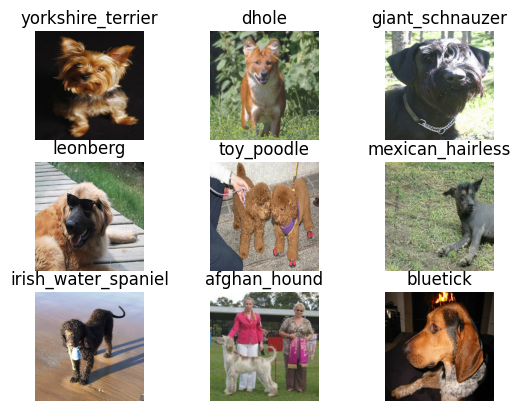

In [9]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


Augmentation

In [10]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

Plotting Augmentation Images

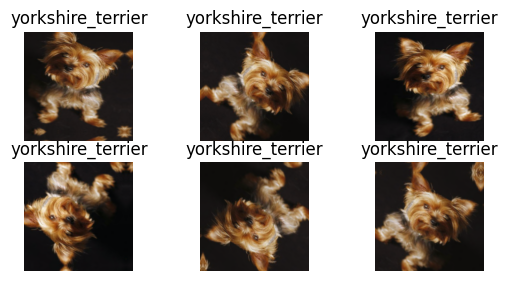

In [11]:
for image, label in ds_train.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

Prepare Input -> One Hot Coding ( Categorical to Numerical Data )

In [12]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

- To improve training efficiency, we can leverage prefetching to overlap data preparation on the CPU with GPU processing, and utilize tf.data.AUTOTUNE to automatically find the optimal prefetch value for our system.
- By hiding data loading delays from the GPU with prefetching, and using autotune to optimize prefetch behavior, we can ensure the GPU is constantly utilized, potentially leading to faster training times.

In [13]:
ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)



Transfer Learning Using Pre-Trained Weight


In [14]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [15]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)


Epoch 1/25
187/187 [==============================] - 149s 740ms/step - loss: 3.2681 - accuracy: 0.4215 - val_loss: 0.8956 - val_accuracy: 0.7319
Epoch 2/25
187/187 [==============================] - 139s 745ms/step - loss: 1.6703 - accuracy: 0.5750 - val_loss: 0.7059 - val_accuracy: 0.7854
Epoch 3/25
187/187 [==============================] - 140s 748ms/step - loss: 1.3192 - accuracy: 0.6308 - val_loss: 0.6658 - val_accuracy: 0.8004
Epoch 4/25
187/187 [==============================] - 135s 719ms/step - loss: 1.2427 - accuracy: 0.6496 - val_loss: 0.7110 - val_accuracy: 0.7852
Epoch 5/25
187/187 [==============================] - 135s 720ms/step - loss: 1.1909 - accuracy: 0.6559 - val_loss: 0.6741 - val_accuracy: 0.7957
Epoch 6/25
187/187 [==============================] - 140s 750ms/step - loss: 1.1336 - accuracy: 0.6734 - val_loss: 0.6785 - val_accuracy: 0.7968
Epoch 7/25
187/187 [==============================] - 134s 715ms/step - loss: 1.1436 - accuracy: 0.6715 - val_loss: 0.6964 -

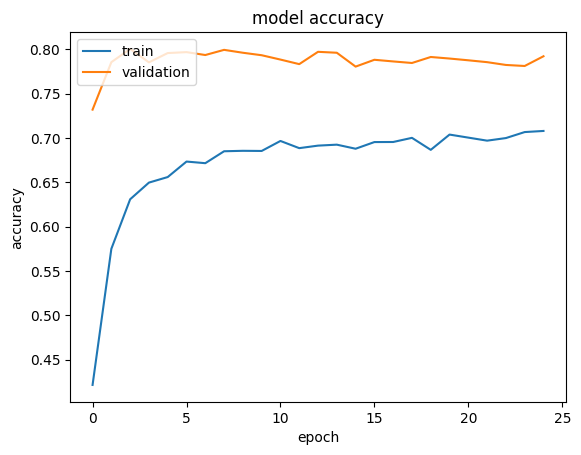

In [18]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)